In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

In [2]:
#Fixed the CSV file to replace NA with None
df = pd.read_csv(r"..\input\train.csv")
test_df = pd.read_csv(r"..\input\test.csv")

test_df.head()



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [3]:
#Get the dummy variables for all features.
# 1 : Numerical : Fill with the mean values
# 2:  Categorical : 1) Replace NA with None, as NA has some meaning. 
#                      Like NA for parking will mean No parking and may effect SaleCost
#Rest all delete the rows

def clean_data(df):
    df['MasVnrType'].fillna("NoNe",inplace=True)
    df['MasVnrArea'].fillna(df['MasVnrArea'].mean(),inplace=True)
    df['BsmtFinSF2'].fillna(df['BsmtFinSF2'].mean(),inplace=True)
    df['BsmtUnfSF'].fillna(df['BsmtUnfSF'].mean(),inplace=True)
    df['TotalBsmtSF'].fillna(df['TotalBsmtSF'].mean(),inplace=True)
    df['BsmtFullBath'].fillna(df['BsmtFullBath'].mean(),inplace=True)
    df['BsmtHalfBath'].fillna(df['BsmtHalfBath'].mean(),inplace=True)
    df['LotFrontage'].fillna(df['LotFrontage'].mean(),inplace=True)
    df['Alley'].fillna("NoNe",inplace=True)
    df['FireplaceQu'].fillna("NoNe",inplace=True)
    df['GarageType'].fillna("NoNe",inplace=True)
    df['GarageYrBlt'].fillna("NoNe",inplace=True)
    df['GarageFinish'].fillna("NoNe",inplace=True)
    df['GarageQual'].fillna("NoNe",inplace=True)
    df['GarageCond'].fillna("NoNe",inplace=True)
    df['PoolQC'].fillna("NoNe",inplace=True)
    df['Fence'].fillna("NoNe",inplace=True)
    df['MiscFeature'].fillna("NoNe",inplace=True)
    df['GarageCars'].fillna(df['GarageCars'].mean(),inplace=True)
    df['GarageArea'].fillna(df['GarageArea'].mean(),inplace=True)
    #For rest of he variables we will drop the data
    df.dropna(axis=0,inplace=True)
    return df
def clean_data_test(df):
    df['MasVnrType'].fillna("NoNe",inplace=True)
    df['MasVnrArea'].fillna(df['MasVnrArea'].mean(),inplace=True)
    df['BsmtFinSF2'].fillna(df['BsmtFinSF2'].mean(),inplace=True)
    df['BsmtUnfSF'].fillna(df['BsmtUnfSF'].mean(),inplace=True)
    df['TotalBsmtSF'].fillna(df['TotalBsmtSF'].mean(),inplace=True)
    df['BsmtFullBath'].fillna(df['BsmtFullBath'].mean(),inplace=True)
    df['BsmtHalfBath'].fillna(df['BsmtHalfBath'].mean(),inplace=True)
    df['LotFrontage'].fillna(df['LotFrontage'].mean(),inplace=True)
    df['Alley'].fillna("NoNe",inplace=True)
    df['FireplaceQu'].fillna("NoNe",inplace=True)
    df['GarageType'].fillna("NoNe",inplace=True)
    df['GarageYrBlt'].fillna("NoNe",inplace=True)
    df['GarageFinish'].fillna("NoNe",inplace=True)
    df['GarageQual'].fillna("NoNe",inplace=True)
    df['GarageCond'].fillna("NoNe",inplace=True)
    df['PoolQC'].fillna("NoNe",inplace=True)
    df['Fence'].fillna("NoNe",inplace=True)
    df['MiscFeature'].fillna("NoNe",inplace=True)
    df['GarageCars'].fillna(df['GarageCars'].mean(),inplace=True)
    df['GarageArea'].fillna(df['GarageArea'].mean(),inplace=True)
    return df
    
def get_dummies(df):
    df = pd.get_dummies(df)
    return df


In [4]:
df = clean_data(df)
test_df = clean_data_test(test_df)
print(df.shape)
print(test_df.shape)

(1420, 81)
(1459, 80)


In [5]:
#convert the categorical variable by adding dummies
df = get_dummies(df)
test_df = get_dummies(test_df)

#Test to see if both the test & train data and same columns
print(test_df.shape)

df['SalePrice'] = np.log(df['SalePrice'])

print(df.shape)


(1459, 378)
(1420, 393)


In [6]:
#Since we have now figure out that train has more columns then test, 
#we can safely assume that no significant feature of the training set will be missing from test set.
#Else we need to get the test database updated.

#Now find the significant features, for the SalePrice
#Will Get the Pearson Correlation with Saleprice with below thresholds


pthreshhold = 0.3
nthreshhold = -0.3

def get_significant_features(df,feature='SalePrice'):
    Corr = pd.DataFrame(df.corr()[feature])
    Corr = Corr[(Corr >  pthreshhold) | (Corr <  nthreshhold ) ]
    #Drop all the not significant values.
    Corr = Corr.dropna()
    return Corr


In [7]:
train_corr = get_significant_features(df,'SalePrice')
train_corr.index



Index(['LotFrontage', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'SalePrice', 'MSZoning_RL',
       'MSZoning_RM', 'Neighborhood_NridgHt', 'Exterior1st_VinylSd',
       'Exterior2nd_VinylSd', 'MasVnrType_None', 'MasVnrType_Stone',
       'ExterQual_Ex', 'ExterQual_Gd', 'ExterQual_TA', 'Foundation_CBlock',
       'Foundation_PConc', 'BsmtQual_Ex', 'BsmtQual_Gd', 'BsmtQual_TA',
       'BsmtFinType1_GLQ', 'HeatingQC_Ex', 'HeatingQC_TA', 'CentralAir_N',
       'CentralAir_Y', 'KitchenQual_Ex', 'KitchenQual_Gd', 'KitchenQual_TA',
       'FireplaceQu_Gd', 'FireplaceQu_NoNe', 'GarageType_Attchd',
       'GarageType_Detchd', 'GarageType_NoNe', 'GarageYrBlt_NoNe',
       'GarageFinish_Fin', 'GarageFinish_NoNe', 'GarageFinish_Unf',
       'GarageQual_NoNe', 'GarageQual_TA', 'GarageCond_

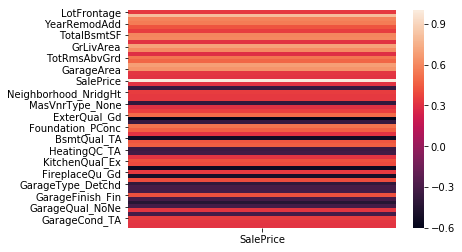

In [8]:
sn.heatmap(train_corr)



In [9]:
def run_reg(X,Y,df):
    #Now lets start the regression model
    model = sm.OLS(Y,X).fit()
    feature_count=1
    while(feature_count !=0):
        score = model.rsquared
        pvalues = model.pvalues
        pvalues = pvalues.drop('const',axis=0)
        #print(score)
        feature_count= len(pvalues[pvalues > 0.05] )
        if(feature_count != 0):
            pvalues = pvalues[pvalues < 0.05]
            X = df[pvalues.index]
            X = sm.add_constant(X)
            lreg = run_reg(X,Y,df)
    return model

In [10]:
#Now lets move the Regression on the significant features
#Now lets start the regression model
#Extract the rigth set of features from df
X = df[train_corr.index]
X = sm.add_constant(X)
Y = df['SalePrice']


In [11]:
df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
lreg = run_reg(X,Y,df)


In [ ]:
model.summary

In [ ]:
pvalues_train = model.pvalues
pvalues_train.drop('const',axis=0,inplace=True)

In [ ]:
for item in pvalues_train:
    sn.relplot(x=item,y='SalePrice',data=df)

In [ ]:
def get_rmse(true_val,pred_val):
    error = true_val-pred_val
    rmse = np.sqrt(np.mean(error**2))
    return rmse

In [ ]:
y_predict_train = model.predict(X)
score_train_no_reg = model.rsquared
rmse_no_reg = get_rmse(Y,y_predict_train)
print("Score Without Regularisation :",score_train_no_reg)
print("RMSE without Regularisation :",rmse_no_reg)


In [ ]:
X['Predicted Value'] = y_predict_train
X['True Value'] = Y
sn.regplot(x='True Value',y='Predicted Value',data=X)

In [ ]:
#Now Run the Ridge Regularization
from  sklearn.linear_model  import Ridge
def reg_alpha(X,Y,alpha,normalize=True):
    lreg = Ridge(alpha)
    model = lreg.fit(X,Y)
    Y_pred = model.predict(X)
    return model,Y_pred,lreg

In [73]:
#Let's start with the model again. We will use only the features with pvalues less that 0.05 
X = df[train_corr.index]
Y = df['SalePrice']

#output = pd.DataFrame(columns= ['alpha','rmse','score'])
output = []
alpha = [100,10,1,0.1,0.01,0.001,0.0001]
count=0
for alpha_val in alpha:
    X = sm.add_constant(X)
    model,Y_pred_alpha,lreg = reg_alpha(X,Y,alpha_val)
    rmse = get_rmse(Y,Y_pred_alpha)
    score = model.score(X,Y)
    output.append((alpha_val,rmse,score))
    count+= 1

output_df = pd.DataFrame(output,columns=['alpha','rmse','score'])
output_df.head()    


,alpha,rmse,score
0,100.00,0.150805,0.853378
1,10.00,0.148772,0.857304
2,1.00,0.148528,0.857773
3,0.10,0.148516,0.857795
4,0.01,0.148516,0.857795


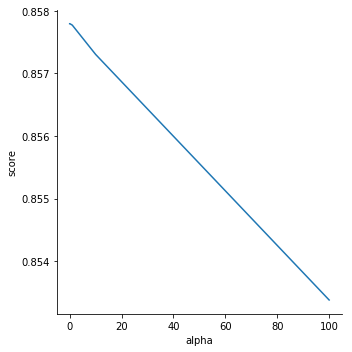

In [74]:
sn.relplot(x='alpha',y='score',kind="line",data=output_df)


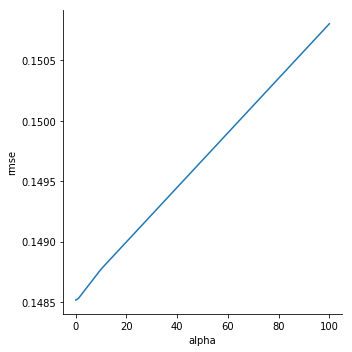

In [75]:
sn.relplot(x='alpha',y='rmse',kind="line",data=output_df)


In [76]:
print(model.score(X,Y))

0.8577950410919193


In [77]:
#Prepare the test data now
X_test = test_df[train_corr.index]
X_test = sm.add_constant(X_test)


In [85]:
#Run the Test data Now
Y_pred_test = model.predict(X_test)
Y_pred_test = np.exp(Y_pred_test)
Y_pred_test

array([111670.83809325, 149881.01783097, 176337.22791964, ...,
       164123.45376359, 111240.2309336 , 234721.54405769])

In [95]:
Predict = pd.DataFrame({'Id': test_df.Id, 'SalePrice': (Y_pred_test)})
Predict.reset_index(drop=True,inplace=True)
Predict.to_csv('submission.csv')
Predict

,Id,SalePrice
0,1461,111670.838093
1,1462,149881.017831
2,1463,176337.227920
3,1464,198564.764083
4,1465,196142.348792
5,1466,175610.781901
6,1467,179426.614523
7,1468,171770.220877
8,1469,190982.400478
9,1470,120185.762665
